# Решение СЛАУ через минимизацию

В предыдущих сериях.

__1__ Минимизация невязки $\|Ax - f\|_2^2$

__2__ Минимизация функционала энергии $(Ax, x) - 2(f, x)$, $A = A^* > 0$

Оба функционала выпуклы и хороши с точки зрения минимизации

# Приближение решения в подпространстве

Мы хотим приблизить решение в $M$-размерном подпространстве $\{y_1, \ldots y_M\}$.

$$Ax \approx f \quad x = x_0 + \sum\limits_{k = 1}^Mc_ky_k$$

или более коротко 
$$x = x_0 + Yc$$

Давайте в таком базисе минимизировать функционал энергии, так как нормальное уравнение в этом случае будет совпадать с исходной системой.

__1__ Подставим выражение для $x$ в $E(x)$, учитывая $x_0$ как константу с точки зрения минимизации следующее будет эквивалентно минимизаци исходного функционала энергии в выбранном базисе.

\begin{align}
    E(c) &= (AYc, Yc) + 2(Y^*Ax_0, x) - 2(f, Yc)\\
    &=(Y^*AYc, c) - 2(Y^*(f - Ax_0), c)
\end{align}

$$E(c) \to \min_c$$
Из условия оптимальномти первого порядка получим:
$$Y^*AYc = Y^*(f - Ax_0) = Y^*r_0$$
$r_0$ -- невязка.

Получили симметричную систему $M\times M$ (даже с положительно определенной матрицей, если $Y$ полного столбцового ранга), но как ее решать? Как выбирать нужное $Y$?

__1__ Подставим выражение для $x$ в "МНК"
$$\|A_x - f\|_2 = \|AYc - r_0\|_2 \to \min_c$$

# Пространство Крылова
$${\cal K}_M(A, r_0) = {\rm Span}(r_0, Ar_0, \ldots, A^{M - 1}r_0)$$

То есть все пространосво порождено единственным ветором и матрицей.

<img src="./image.jpg">

По теореме из линала

$$p(A) = 0, \quad p(\lambda) = \det(A - \lambda I)$$

Тогда
$$p(A)f = 0 = A^nf + a_1A^{n - 1}f + \ldots + a_n f \mid A^{-1}~from~left$$
$$x^* = A^{-1}f = -\frac{1}{a_n}(A^{n - 1}f + \ldots + a_{n - 1}f)$$
$$x^* \in {\cal K}_n(A, f)$$

- НО

Базис Крылова будет плохо обусловлен

- Почему?

$$A^k r_0 \to \lambda_{\max}\nu, \quad k \to \infty$$
Вектора в базисе становятся все более и более коллинеарными с ростом их числа.

- Что делать?

__QR-разложение__
$$K_M = [r_0,~Ar_0, \ldots, A^{M - 1}r_0] = Q_MR_M$$
$$x \approx x_0 + Q_M c$$

# Арнольди

Для матрицы Крылова $K_M$ верно следующее
$$AQ_M = Q_MH_M + h_{M, M - 1}q_Me_{M - 1}^{\top}$$

Где $H_M$ верхняя Гейзенбергова, $Q_{M + 1} = [q_0, \ldots q_M]$ столбцы принадлежат пространству, натянутому на столбцы матрицы $K_{M + 1}$

<img src="./Hessenberg.png">

Для несимметричного случая это просто моифицированная ортогонализация Г-Ш

Для случая симматричной матрицы формулы становятся проще и это называется процессом Ланцоша, а верхне Гейзенбергова превращается а трехдиагональную.

Псевдокод
```python
#Start with an arbitrary vector $q_1$ with norm 1.
q_k = q_1
for k in [2, ... , M]:
    q_k = A
    for j in [1, ..., k - 1]:
        h_j_k_prev = q_j.H@q_k
        q_k -= h_j_k_prev q_j
    h_k_k_prev = norm(q_k)
    q_k /= h_k_k_prev

```

# Не симметричные системы, generalized minimal residual method (GMRES)

У нас есть это соотношение, а давайте в выражение для невязки подставим.

$$x_j = x_0 + Q_Jc_j$$
$$\|Ax_j - f\|_2 = \|AQ_jc_j - r_0\|_2 \to \min_{c_j}$$
$$\|Q_{j + 1}\hat{H}_jc_j - r_0\|_2 \to \min_{c_j}$$
Унитарная инвариантность

$$\|\hat{H}_jc_j - \gamma e_0\|_2 \to \min_{c_j},~\quad Q_{j + 1}^*r_0 = \gamma e_0$$
$$Q_{j + 1}^*r_0 = \|r_0\|^2e_0 = \gamma e_0$$


- МНК на $(j + 1)$ уравнений и $j$ неизвестных
- Для верхней гейзенберговой QR-разложение просто находится
- Минимизирует невязку
- Никаких нормальных уравнений
- Память $O(j^2)$, рестарты


<Figure size 720x360 with 0 Axes>

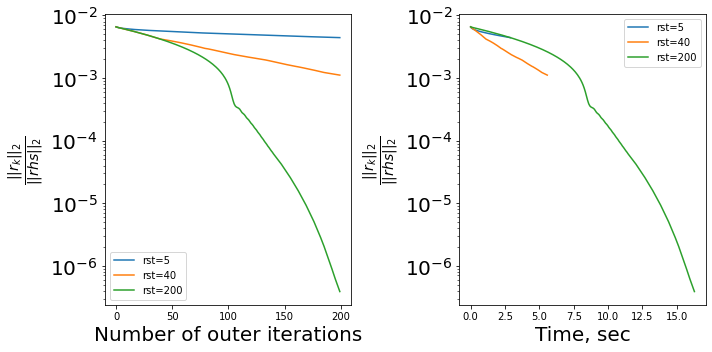

In [10]:
import scipy as sp
import scipy.sparse.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline
n = 150
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)

plt.figure(figsize=(10, 5))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for restart in [5, 40, 200]:
    hist = []
    def callback(rk):
        hist.append(np.linalg.norm(rk) / np.linalg.norm(rhs))
    st = time.time()
    sol = la.gmres(A, rhs, x0=np.zeros(n*n), maxiter=200, restart=restart, callback=callback, tol=1e-16)
    current_time = time.time() - st
    ax1.semilogy(np.array(hist), label='rst={}'.format(restart))
    ax2.semilogy([current_time * i / len(hist) for i in range(len(hist))], np.array(hist), label='rst={}'.format(restart))
    
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Number of outer iterations", fontsize=20)
ax2.set_xlabel("Time, sec", fontsize=20)
ax1.set_ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
ax2.set_ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
plt.sca(ax1)
plt.yticks(fontsize=20)
plt.sca(ax2)
plt.yticks(fontsize=20)
f.tight_layout()

# Сопряженные градиенты 

Рассматриваем симметричную положительно определенную матрицу.

Мы должны работать и уравнение Галеркина + Ланцршем, в учебнике можно найти вывод этого метода с использованием LU-разложения верхнетреугольной матрицы.

Просто итерации:

$$r_j = f - Ax_j$$
$$x_j = x_{j - 1} + \alpha_{j - 1}p_{j - 1}$$
$$r_j = r_{j - 1} - \alpha_{j - 1}Ap_{j - 1}$$
$$p_j = r_{j} + \beta{j}p_{j - 1}$$

- Ортогональность невязок
$$(r_i, r_j) = 0$$
- $A$-ортогональность сопряженных направений $p_{j - 1}$
$$(Ap_i, p_j) = 0$$

$\alpha, \beta$ могут быть найдены из этих условий явным образом.

$$(r_j, r_{j - 1}) = 0 = (r_{j - 1} - \alpha_{j - 1}Ar_{j - 1}, r_{j - 1})$$
$$\alpha_{j - 1} = \frac{(r_{j - 1}, r_{j - 1})}{(Ar_{j - 1}, r_{j - 1})}$$

- Нужно хранить только 3 вектора
- После $N$ шагов сопряженные направения относительно матрицы должны закончится
- Из-за плавающей точки этого нет на практике

# A-норма, сходимость
$$(A(x - y), x - y) = \|x - y\|^2_A$$

Сходимость почти как у метода Чебышева

$$\frac{\|x_k - x^*\|_A}{\|x^*\|_A} \leq C q^k, \quad q = \frac{\sqrt{{\rm cond}(A)} - 1}{\sqrt{{\rm cond}(A)} + 1}$$

$$\|x_k - x^*\|_A = \inf_p\|(p(A) - A^{-1})f\|_A$$
$$A = U\Lambda U^*$$
Тогда
$$\|x_k - x^*\|_A = \inf_p \sum\limits_{k = 1}^n\frac{\lambda_ip(\lambda_i) - 1}{\lambda_i}C$$
$$\|x_k - x^*\|_A \leq \inf_{q, q(0) = 1}\max_j|q(\lambda_j)|$$

# MINRES

MINRES = GMRES с симметричной матрицей

# GMRES рестарты
После того как нашли некоторое приближенное решение переходим к следующему витку

$$A(x + e) = f, \quad Ae = f - Ax$$

Это портит сходимость

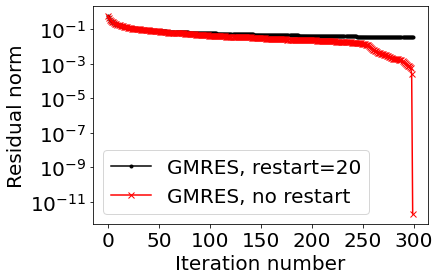

In [11]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

n = 300
ex = np.ones(n);
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)

res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r))
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r))

sol = scipy.sparse.linalg.gmres(A, rhs, restart=20, callback=gmres_rst_cl)
sol = scipy.sparse.linalg.gmres(A, rhs, restart=n, callback=gmres_rst)

lim = 300
plt.semilogy(res_gmres_rst[:lim], marker='.',color='k', label='GMRES, restart=20')
plt.semilogy(res_gmres[:lim], marker='x',color='r', label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Альтернатива: biconjugate gradient
__1__ Используем нормальное уравнение $A^*Ax = A^*f$

__2__ Использовать два пространства Крылова: для $A$ & $A^*$

__3__ Нужна стабилизация из-за числа обусловленности теперь.



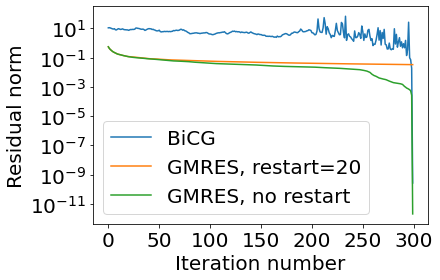

In [12]:
res_all_bicg = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))
    
sol = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(n), callback=bicg_cl)
plt.semilogy(res_all_bicg, label='BiCG')
plt.semilogy(res_gmres_rst[:n], label='GMRES, restart=20')
plt.semilogy(res_gmres, label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

Dimension of the linear system = 300


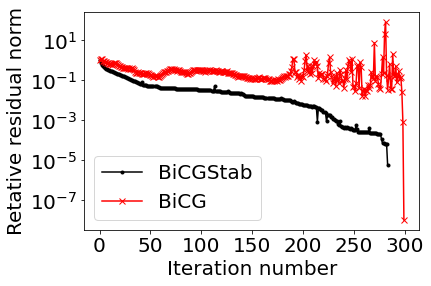

In [13]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

n = 300

ex = np.ones(n);
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr') 
rhs = np.random.randn(n)

# ee = sp.sparse.eye(n)
# A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr')
# A = sp.sparse.kron(A, ee) + sp.sparse.kron(ee, A)
# rhs = np.ones(n * n)

print("Dimension of the linear system = {}".format(A.shape[0]))

res_all_bicg = []
res_all_bicgstab = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))

def bicgstab_cl(x):
    res_all_bicgstab.append(np.linalg.norm(A.dot(x) - rhs))

sol2 = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(A.shape[0]), callback=bicg_cl)
sol2 = scipy.sparse.linalg.bicgstab(A, rhs, x0=np.zeros(A.shape[0]), callback=bicgstab_cl)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]
res_all_bicgstab = np.array(res_all_bicgstab)/res_all_bicgstab[0]

lim = 350
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')

plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Retative residual norm', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)